In [6]:
import re
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

log_files = [
    # tmp:
    '/data/zlt/RemoteSensePET/outputs/tmp_',
    '/data/zlt/RSPET/PET/outputs/SHA/pet_model',
    # arch:
    '/data/zlt/RSPET/PET/outputs/SHA/vgg_baseline',
    '/data/zlt/RSPET/PET/outputs/SHA/vgg_baseline_enpet',
    '/data/zlt/RSPET/PET/outputs/SHA/vgg_f4x',
    '/data/zlt/RSPET/PET/outputs/SHA/vgg_lossmixed',
    '/data/zlt/RSPET/PET/outputs/SHA/vgg_probloss',
    '/data/zlt/RSPET/PET/outputs/SHA/vgg_probloss_Focal',
]

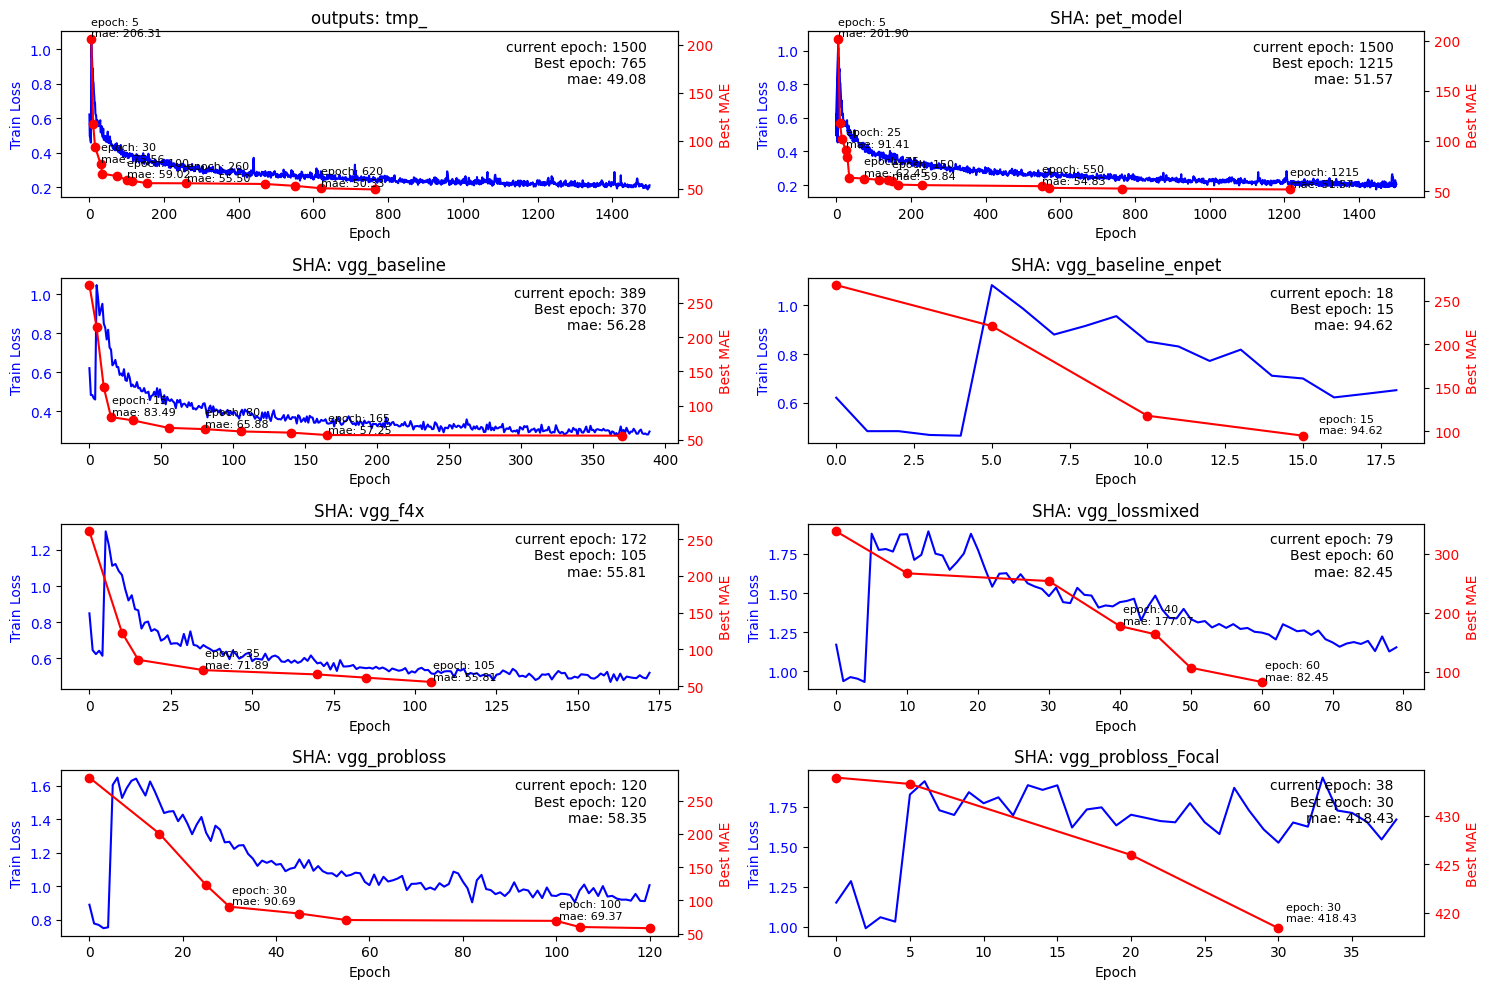

In [11]:
fig, axs = plt.subplots(4, 2, figsize=(15, 10))
p_x = 0
p_y = 0

for log_file in log_files: #[log_file1, log_file2, log_file3, log_file4]:
    log_file = log_file + '/run_log.txt' if 'tmp_' not in log_file else log_file + '/SHA_log.txt'
    epochs = []
    train_losses = []
    best_maes = []
    best_epochs = []
    with open(log_file, 'r') as f:
        current_best_mae = float('inf')
        for line in f:
            if '[ep' in line:
                json_str = re.search(r'{.*}', line)
                if json_str:
                    data = json.loads(json_str.group())
                    epochs.append(data['epoch'])
                    train_losses.append(data['train_loss'])
            
            elif 'best mae' in line:
                best_info = re.search(r'best mae:(\d+\.\d+), best epoch: (\d+)', line)
                if best_info:
                    mae = float(best_info.group(1))
                    epoch = int(best_info.group(2))
                    if mae < current_best_mae:
                        current_best_mae = mae
                        best_maes.append(mae)
                        best_epochs.append(epoch)

    window = 3
    train_losses_smoothed = pd.Series(train_losses).ewm(span=window, adjust=False).mean().values
    train_losses_smoothed = train_losses
    
    ax1 = axs[p_y, p_x]  
    if p_x == 0:
        p_x = 1
    else:
        p_x = 0
        p_y += 1
        
    ax1.plot(epochs, train_losses_smoothed, label='Smoothed Train Loss', color='blue')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(best_epochs, best_maes, label='Best MAE', color='red', marker='o')
    count_print = 0
    
    targets = [100, 500, 1000]
    target_best_epochs = {}

    for t in targets:
        for x in reversed(best_epochs):
            if x < t:
                target_best_epochs[t] = x
                break
    
    for x, y in zip(best_epochs, best_maes):
        if x > 0 and count_print % 3 == 0: #x in target_best_epochs.values():    #count_print % 7 == 0 or x == best_epochs[-1]:
            ax2.text(x + 0.5, y + 0.5, f'epoch: {x}\nmae: {y:.2f}', fontsize=8, ha='left', va='bottom')
        count_print += 1

    x_bias = int(best_epochs[-1] * 0.167)
    y_bias = int(train_losses[0] * 30)
    log_name = log_file.split('/')[-3] + ': ' + log_file.split('/')[-2]
    # ax2.text(x -x_bias , y + 16, f'Best epoch: {x}\nmae: {y:.2f}', fontsize=8, ha='left', va='bottom')
    ax2.text( 0.95, 0.95, f'current epoch: {epochs[-1]}\nBest epoch: {x}\nmae: {y:.2f}', transform=ax2.transAxes,  fontsize=10, ha='right',va='top')
    ax2.set_ylabel('Best MAE', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    fig.tight_layout()
    ax1.set_title(f'{log_name}')

# fig.savefig('exs_ship.pdf', bbox_inches='tight')
plt.show()
